In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

# Load Data


In [ ]:
import pickle
import gensim
data = pickle.load(open("/content/drive/MyDrive/GAN_Text_to_images/image_vectors.p", "rb"))
word_vector = pickle.load(open("/content/drive/MyDrive/GAN_Text_to_images/word_vector_min_bird.p", "rb"))
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GAN_Text_to_images/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final
# print(model["Bird"])

## Agumentation Data


In [ ]:
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import expand_dims
from random import randint, choice
import numpy as np

def random_flip(image):
  image = tf.image.flip_left_right(image)
  return image.numpy()

def random_jitter(image):

  image = expand_dims(image, 0) #add additional dimension necessary for zooming
  image = image_augmentation_generator.flow(image, batch_size=1)
  result = image[0].reshape(image[0].shape[1:]) #remove additional dimension (1, 64, 64, 3) to (64, 64, 3)
  return result
image_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.8, 1.0]) # random zoom proves to be helpful in capturing more details https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/



# Load anh, word vector, label

In [ ]:
n = 227
image_embeddings = []
captions = []
labels = []
for i, k in enumerate(data.keys()):
  image_embeddings.append(data[k])
  captions.append(word_vector[k])
  labels.append(k)
  if i % n == 0:
   image_embeddings.append(random_jitter(data[k]))
   captions.append(word_vector[k])
   labels.append(k)

# print(len(captions))
# print(len(image_embeddings))
# print(len(labels))



In [ ]:
# print(captions[2].shape)
# print(labels[2].shape)
# print(image_embeddings[2].shape)


Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0002_55.jpg
Black_Footed_Albatross_0003_796136.jpg
Black_Footed_Albatross_0005_796090.jpg
Black_Footed_Albatross_0006_796065.jpg
Black_Footed_Albatross_0007_796138.jpg
Black_Footed_Albatross_0008_796083.jpg
Black_Footed_Albatross_0009_34.jpg


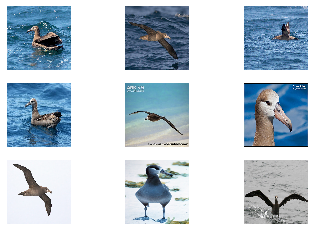

In [ ]:
import cv2
import numpy as np

pyplot.axis('off')
slcie = image_embeddings[25:35]
for i in range(len(slcie)-1):
  pyplot.subplot(3, 3, i+1)
  pyplot.imshow(array_to_img(slcie[i]))
  print(labels[i])
  pyplot.axis('off')

pyplot.show()


# Lay caption ngau nhien

In [ ]:
import numpy as np

def get_random_word_vectors_from_dataset(n_samples):
  ix = np.random.randint(0, len(captions), n_samples) # Lay ngau nhien n captions
  return np.asarray(captions)[ix]
# print(get_random_word_vectors_from_dataset(2))

# Lay vector nhieu ngau nhien


In [ ]:

def generate_random_vectors(n_samples):  
  vectorized_random_captions = []

  for n in range(n_samples):
    rnd = randint(8, 25)
    result_array = np.empty((0, 300))
    for i in range(rnd):
      result_array = np.append(result_array, [model[choice(model.index2entity)]], axis=0)
    vectorized_random_captions.append(np.mean(result_array, axis=0).astype('float32'))

  return np.array(vectorized_random_captions)
# print(generate_random_vectors(3).shape)


In [ ]:
# result_array = np.empty((0, 300))
# result_array = np.append(result_array, [model[choice(model.index2entity)]], axis=0)
# print(result_array)

# Build Model

In [ ]:
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np
import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
from keras.layers.advanced_activations import PReLU
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output





## Discriminator

In [ ]:
def define_discriminator():
    word_vector_dim = 300
    dropout_prob = 0.4

     # Concatenate word_vector and image
    # Captions
    in_label = layers.Input(shape=(300,))
    n_nodes = 3 * 64 * 64
    li = layers.Dense(n_nodes)(in_label)
    li = layers.Reshape((64, 64, 3))(li)
    # Images
    dis_input = layers.Input(shape=(64, 64, 3))
    merge = layers.Concatenate()([dis_input, li])

    # Lop tich chap thu 1
    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(merge)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.GaussianNoise(0.2)(discriminator)
 
  # Lop tich chap thu 2
    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU()(discriminator)

  # Lop tich chap thu 3
    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

  # Lop tich chap thu 4
    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

  # Lop tich chap thu 5
    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

  #Lop tich chap thu 6
    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

  #Lop tich chap thu 7
    discriminator = layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Flatten()(discriminator)
    discriminator = layers.Dense(1024)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.Dense(1)(discriminator)
    discriminator_model = Model(inputs=[dis_input, in_label], outputs=discriminator)
    discriminator_model.summary()

    return discriminator_model
a = define_discriminator()

## Generator

In [ ]:
def resnet_block(model, kernel_size, filters, strides):
    gen = model
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen, model])
    return model


# Generator model
def define_generator():
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    batch_init = tf.random_normal_initializer(1., 0.02)

  # Captions

    text_input1 = layers.Input(shape=(300,))
    text_layer1 = layers.Dense(8192)(text_input1)
    text_layer1 = layers.Reshape((8, 8, 128))(text_layer1)

  # Noisy vector
    random_input = layers.Input(shape=(100,))
    n_nodes = 128 * 8 * 8
    gen_input_dense = layers.Dense(n_nodes)(random_input)
    generator = layers.Reshape((8, 8, 128))(gen_input_dense)

  # Concatenate 
    merge = layers.Concatenate()([generator, text_layer1])

  #Resnetblock 4 lop
    model = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(merge)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)

    gen_model = model

    for _ in range(4):
      model = resnet_block(model, 3, 64, 1)

  # Output resnet
    model = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen_model, model])

  #Giai chap 1 
    model = layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

  # Giai chap 2
    model = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

  # Giai chap 3
    model = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

  # Giai chap 4
    model = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(model)

    generator_model = Model(inputs=[random_input, text_input1], outputs=model)

    generator_model.summary()

    return generator_model
b= define_generator()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 8192)         2465792     ['input_3[0][0]']                
                                                                                            

# Loss funtion

In [ ]:
from IPython.display import clear_output

def generate_latent_points(latent_dim, n_samples):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions = get_random_word_vectors_from_dataset(n_samples)
    return [x_input, text_captions]


In [ ]:

# Randomly flip some labels. Credits to https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
def noisy_labels(y, p_flip):
    n_select = int(p_flip * int(y.shape[0]))
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs

In [ ]:
def load_data():
    return asarray(image_embeddings), asarray(captions).astype('float32')

In [ ]:
def smooth_positive_labels(y):
	return y - 0.3 + (np.random.random(y.shape) * 0.5)

In [ ]:
def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[7, 7])

  for i in range(predictions.shape[0]):
      pyplot.subplot(5, 5, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()

## Discriminator loss

In [ ]:
def discriminator_loss(r_real_output_real_text, f_fake_output_real_text_1, f_real_output_fake_text):
   alpha = 0.5
   real_output_noise = smooth_positive_labels(noisy_labels(tf.ones_like(r_real_output_real_text), 0.10))
   fake_output_real_text_noise_1 = smooth_negative_labels(tf.zeros_like(f_fake_output_real_text_1))
   real_output_fake_text_noise = smooth_negative_labels(tf.zeros_like(f_real_output_fake_text))

   real_loss = tf.reduce_mean(binary_cross_entropy(real_output_noise, r_real_output_real_text))
   fake_loss_ms_1 = tf.reduce_mean(binary_cross_entropy(fake_output_real_text_noise_1, f_fake_output_real_text_1))
   fake_loss_2 = tf.reduce_mean(binary_cross_entropy(real_output_fake_text_noise, f_real_output_fake_text))

   total_loss = real_loss + alpha * fake_loss_2 + (1-alpha) * fake_loss_ms_1 
   return total_loss

## Generator loss

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(f_fake_output_real_text):
   return tf.reduce_mean(binary_cross_entropy(tf.ones_like(f_fake_output_real_text), f_fake_output_real_text))

# Train

## Setup

In [ ]:
@tf.function
def train_step(images, epoch):

  #define half_batch
  latent_dim = 100
  n_batch = 64
  beta=0.5

  noise_1 = tf.random.normal([32, latent_dim])
  noise_2 = tf.random.normal([32, latent_dim])
  noise_INT = tf.random.normal([32,latent_dim])
  real_captions = images[1]
  real_images = images[0]

  random_captions = generate_random_vectors(n_batch)

  random_captions_1, random_captions_2  = tf.split(random_captions, 2, 0)
  real_captions_1, real_captions_2  = tf.split(real_captions, 2 ,0)
  real_images_1, real_images_2 = tf.split(real_images, 2, 0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    noise = tf.concat([noise_1, noise_2], 0)

    

    # Gen INT
    caption_INT = beta*real_captions_1 + (1-beta)*real_captions_2
    generated_images_INT = generator([noise_INT,caption_INT],training= True)
    f_fake_output_INT = discriminator([generated_images_INT,caption_INT],training=True)

    #Gen_normal
    generated_images = generator([noise, real_captions], training=True)
    fake_1, fake_2 = tf.split(generated_images, 2, 0)

    f_fake_output_real_text_1 = discriminator([fake_1, real_captions_1], training=True)
    f_fake_output_real_text_2 = discriminator([fake_2, real_captions_2], training=True)
    
    r_real_output_real_text_1 = discriminator([real_images_1, real_captions_1], training=True)
    r_real_output_real_text_2 = discriminator([real_images_2, real_captions_2], training=True)

    f_real_output_fake_text_1 = discriminator([real_images_1, random_captions_1], training=True)
    f_real_output_fake_text_2 = discriminator([real_images_2, random_captions_2], training=True)

    #### Calculating losses ####

    gen_loss = generator_loss(f_fake_output_real_text_1) + generator_loss(f_fake_output_real_text_2)
    gen_loss_INT = generator_loss(f_fake_output_INT) 
    # mode seeking loss
    lz = tf.math.reduce_mean(tf.math.abs(fake_2-fake_1)) / tf.math.reduce_mean(tf.math.abs(noise_2-noise_1))
    eps = 1 * 1e-5
    loss_lz = 1 / (eps+lz) * ms_loss_weight
    
    total_gen_loss = gen_loss + loss_lz + gen_loss_INT

    # tf.print('G_loss', [total_gen_loss])

    disc_loss_1 = discriminator_loss(r_real_output_real_text_1, f_fake_output_real_text_1, f_real_output_fake_text_1)
    disc_loss_2 = discriminator_loss(r_real_output_real_text_2, f_fake_output_real_text_2, f_real_output_fake_text_2)
    
    f_output_real_text_INT = smooth_negative_labels(tf.zeros_like(f_fake_output_INT))
    disc_loss_3 = tf.reduce_mean(binary_cross_entropy(f_fake_output_INT, f_output_real_text_INT))
    
    total_disc_loss = disc_loss_1 + disc_loss_2 + disc_loss_3

    # tf.print('D_loss', [total_disc_loss])

    #### Done calculating losses ####

  gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)  

  gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)    

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))





In [ ]:
# noise_1 = tf.random.normal([32, 64])
# noise_2 = tf.random.normal([32, 64])
# noise = tf.concat([noise_1, noise_2], 0)
# print(noise)

# Train gen truoc

In [ ]:
def train_gen(images,epoch):
   #define half_batch
  latent_dim = 100
  n_batch = 64

  noise_1 = tf.random.normal([32, latent_dim])
  noise_2 = tf.random.normal([32, latent_dim])
  real_captions = images[1]
  real_images = images[0]

  random_captions = generate_random_vectors(n_batch)
  random_captions_1, random_captions_2  = tf.split(random_captions, 2, 0)
  real_captions_1, real_captions_2  = tf.split(real_captions, 2 ,0)
  real_images_1, real_images_2 = tf.split(real_images, 2, 0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    noise = tf.concat([noise_1, noise_2], 0)

    generated_images = generator([noise, real_captions], training=True)

    fake_1, fake_2 = tf.split(generated_images, 2, 0)

    f_fake_output_real_text_1 = discriminator([fake_1, real_captions_1], training=True)
    f_fake_output_real_text_2 = discriminator([fake_2, real_captions_2], training=True)

    r_real_output_real_text_1 = discriminator([real_images_1, real_captions_1], training=True)
    r_real_output_real_text_2 = discriminator([real_images_2, real_captions_2], training=True)

    f_real_output_fake_text_1 = discriminator([real_images_1, random_captions_1], training=True)
    f_real_output_fake_text_2 = discriminator([real_images_2, random_captions_2], training=True)

    #### Calculating losses ####

    gen_loss = generator_loss(f_fake_output_real_text_1) + generator_loss(f_fake_output_real_text_2) 
    # mode seeking loss
    lz = tf.math.reduce_mean(tf.math.abs(fake_2-fake_1)) / tf.math.reduce_mean(tf.math.abs(noise_2-noise_1))
    eps = 1 * 1e-5
    loss_lz = 1 / (eps+lz) * ms_loss_weight
    total_gen_loss = gen_loss + loss_lz

    tf.print('G_loss', [total_gen_loss])

    disc_loss_1 = discriminator_loss(r_real_output_real_text_1, f_fake_output_real_text_1, f_real_output_fake_text_1)
    disc_loss_2 = discriminator_loss(r_real_output_real_text_2, f_fake_output_real_text_2, f_real_output_fake_text_2)
    
    total_disc_loss = disc_loss_1 + disc_loss_2

    tf.print('D_loss', [total_disc_loss])

    #### Done calculating losses ####

  # gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)  

  gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)    

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  # discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train Gen and Dis

In [ ]:
def train(dataset, epochs = 40):

  checkpoint_dir = '/content/drive/MyDrive/GAN_Text_to_images/Checkpoint'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=2)
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)  #ckpt_manager.checkpoints[3]
    print ('Latest checkpoint restored!!')

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, epoch) 

    # if (epoch +1) % 10 == 0:
    #   [z_input, labels_input] = generate_latent_points(100, 25)
    #   generate_and_save_images(generator,
    #                         epoch + 1,
    #                          [z_input, labels_input])

    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    if (epoch +1) % 20 == 0:
      

    
      # clear_output(wait=True)
      # discriminator.save('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/discriminator_3.h5')
      generator.save('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/Gen_4.h5')    

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))



## Trainning

In [ ]:
ms_loss_weight = 1.0

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)

# discriminator = define_discriminator()
# generator = define_generator()
discriminator = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/discriminator_4.h5')
generator = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/Gen_4.h5')


images, lbs = load_data()
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((images,lbs)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset,100)

Latest checkpoint restored!!
Time for epoch 1 is 207.744225025177 sec
Time for epoch 2 is 191.0996401309967 sec
Time for epoch 3 is 189.96216654777527 sec
Time for epoch 4 is 190.16751527786255 sec
Saving checkpoint for epoch 5 at /content/drive/MyDrive/GAN_Text_to_images/Checkpoint/ckpt-15
Time for epoch 5 is 193.58360052108765 sec
Time for epoch 6 is 190.5529716014862 sec
Time for epoch 7 is 189.9203896522522 sec
Time for epoch 8 is 189.62509608268738 sec
Time for epoch 9 is 189.89139366149902 sec
Saving checkpoint for epoch 10 at /content/drive/MyDrive/GAN_Text_to_images/Checkpoint/ckpt-16
Time for epoch 10 is 194.38834810256958 sec
Time for epoch 11 is 191.25807166099548 sec
Time for epoch 12 is 189.97850918769836 sec
Time for epoch 13 is 189.74359941482544 sec
Time for epoch 14 is 189.72415947914124 sec
Saving checkpoint for epoch 15 at /content/drive/MyDrive/GAN_Text_to_images/Checkpoint/ckpt-17
Time for epoch 15 is 193.9498929977417 sec
Time for epoch 16 is 190.43450617790222 se

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Time for epoch 20 is 194.3926568031311 sec


## Save Model


In [ ]:
generator.save('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/Gen_4.h5')
discriminator.save('/content/drive/MyDrive/GAN_Text_to_images/Model/Train4/discriminator_4.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Prediction

In [ ]:
#
from keras.preprocessing.image import array_to_img
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np
import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import linspace
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
from numpy.random import randint
import numpy as np
import pandas as pd
import pickle
import random
import gensim
import pickle
import os
from nltk.tokenize import word_tokenize
import re
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Xử lý captions 

In [ ]:
def clean_and_tokenize_comments_for_image(comment):
    stop_words = ['a', 'and', 'of', 'to']
    punctuation = r"""!"#$%&'()*+,./:;<=>?@[\]^_`…’{|}~"""
    comments_without_punctuation = [s.translate(str.maketrans(' ', ' ', punctuation)) for s in comment]
    sentences = []

    for q_w_c in comments_without_punctuation:
        q_w_c = re.sub(r"-(?:(?<!\b[0-9]{4}-)|(?![0-9]{2}(?:[0-9]{2})?\b))", ' ', q_w_c)  # replace with space

        temp_tokens = word_tokenize(str(q_w_c).lower())
        tokens = [t for t in temp_tokens if t not in stop_words]
        sentences.append(tokens)
    return np.array((sentences))
print(clean_and_tokenize_comments_for_image("This is a book").shape)

(14,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


# Predcition


In [ ]:
def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final

In [ ]:
def generate_random_word_vectors_from_dataset(n_samples, create_new_captions = False):

  if create_new_captions:
      e = create_sent_vector('Orange bird with black wings  head feathers')
      f = create_sent_vector('Orange bird with black wings  head feathers')
      v = []
      flag = False
      for i in range(n_samples):
        
        if not flag:
          v.append(f)
          flag = True
        elif flag:
          v.append(e)
          flag = False
      return np.asarray(v), np.asarray([])
  else:
    ix = randint(0,len(captions), n_samples)
    print(ix)
    return  np.asarray(captions)[ix], np.asarray(labels)[ix]



In [ ]:
def generate_images(model, test_input):

  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[15, 15])
  for i in range(predictions.shape[0]):
      pyplot.subplot(1, 9, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.show()




In [ ]:
def interpolate_points(p1, p2, n_steps=9):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)


In [ ]:
 def generate_latent_points(latent_dim, n_samples, interpolate = False):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_random_word_vectors_from_dataset(n_samples, create_new_captions=False)
    if interpolate:
      text_captions = interpolate_points(text_captions[0], text_captions[1])
      x_input = interpolate_points(x_input[0], x_input[1])
    for index, s in enumerate(labels.flat):
      print(index, s)

    return [x_input, text_captions]

[2913 1262 6994 7370 3394 6085 4018 5031 3997]
0 Horned_Grebe_0019_34811.jpg
1 Brandt_Cormorant_0038_23110.jpg
2 Field_Sparrow_0126_113426.jpg
3 Nelson_Sharp_Tailed_Sparrow_0015_796922.jpg
4 California_Gull_0028_40666.jpg
5 American_Pipit_0046_100240.jpg
6 Rufous_Hummingbird_0109_60021.jpg
7 Pacific_Loon_0048_75524.jpg
8 Rufous_Hummingbird_0052_59581.jpg
(9, 64, 64, 3)


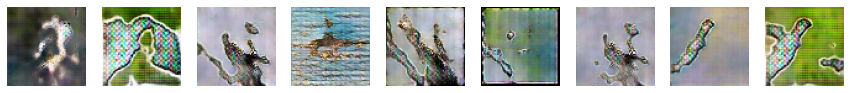

[ 1892  8138  8440 10762   368  4778  5435  5005  2519]
0 Gray_Crowned_Rosy_Finch_0018_26978.jpg
1 Tree_Swallow_0115_135832.jpg
2 Caspian_Tern_0123_145774.jpg
3 Yellow_Warbler_0112_176301.jpg
4 Parakeet_Auklet_0067_795964.jpg
5 Ringed_Kingfisher_0039_71052.jpg
6 Clark_Nutcracker_0076_85083.jpg
7 Pacific_Loon_0021_75859.jpg
8 Frigatebird_0082_42989.jpg
(9, 64, 64, 3)


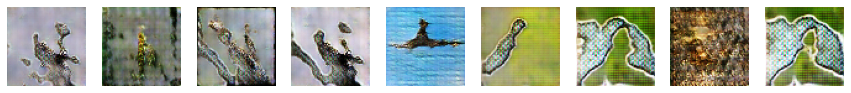

[ 8075 10942  5017  5222  4726 11586  5525  1339  6336]
0 Cliff_Swallow_0098_133130.jpg
1 Bohemian_Waxwing_0113_177823.jpg
2 Pacific_Loon_0034_75438.jpg
3 Hooded_Merganser_0087_78972.jpg
4 Pied_Kingfisher_0062_72379.jpg
5 House_Wren_0118_187383.jpg
6 White_Breasted_Nuthatch_0129_86761.jpg
7 Red_Faced_Cormorant_0063_796284.jpg
8 White_Necked_Raven_0055_797352.jpg
(9, 64, 64, 3)


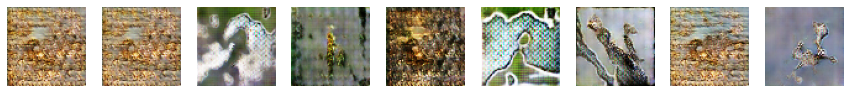

[3451 9146 6652  868 8476 4853  654  844 9643]
0 Glaucous_Winged_Gull_0015_44198.jpg
1 Warbling_Vireo_0116_158740.jpg
2 Black_Throated_Sparrow_0015_107079.jpg
3 Painted_Bunting_0054_16711.jpg
4 Common_Tern_0077_149196.jpg
5 White_Breasted_Kingfisher_0087_73264.jpg
6 Yellow_Headed_Blackbird_0089_8326.jpg
7 Painted_Bunting_0005_15202.jpg
8 Cerulean_Warbler_0017_797198.jpg
(9, 64, 64, 3)


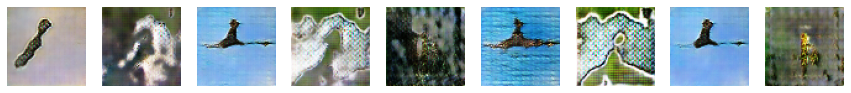

[7655 7469  492 2126  361 4924 9204 1047 8974]
0 Tree_Sparrow_0125_123078.jpg
1 Savannah_Sparrow_0116_118108.jpg
2 Red_Winged_Blackbird_0011_5845.jpg
3 Great_Crested_Flycatcher_0012_29264.jpg
4 Parakeet_Auklet_0056_795926.jpg
5 Red_Legged_Kittiwake_0069_795435.jpg
6 White_Eyed_Vireo_0125_159078.jpg
7 Gray_Catbird_0111_19550.jpg
8 Philadelphia_Vireo_0002_156591.jpg
(9, 64, 64, 3)


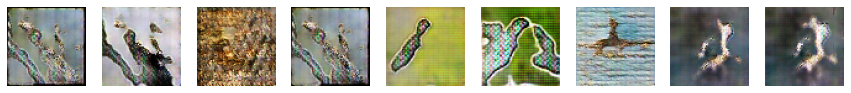

[6070 2715 1384 6323 7776 9472 2778 6540 7802]
0 American_Pipit_0019_99810.jpg
1 American_Goldfinch_0129_32625.jpg
2 Pelagic_Cormorant_0057_24002.jpg
3 White_Necked_Raven_0040_797386.jpg
4 White_Crowned_Sparrow_0127_126923.jpg
5 Blue_Winged_Warbler_0035_161741.jpg
6 European_Goldfinch_0104_794634.jpg
7 Great_Grey_Shrike_0015_797031.jpg
8 White_Throated_Sparrow_0043_128818.jpg
(9, 64, 64, 3)


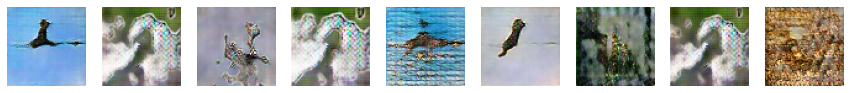

[ 3693 11595   709  4767  6349  8445  6991  3692 10802]
0 Ring_Billed_Gull_0027_51266.jpg
1 House_Wren_0133_187101.jpg
2 Bobolink_0107_10252.jpg
3 Ringed_Kingfisher_0021_72848.jpg
4 White_Necked_Raven_0072_797391.jpg
5 Common_Tern_0014_149194.jpg
6 Field_Sparrow_0123_113847.jpg
7 Ring_Billed_Gull_0021_51300.jpg
8 Northern_Waterthrush_0063_177346.jpg
(9, 64, 64, 3)


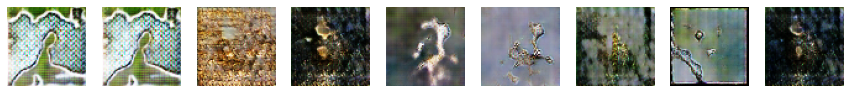

[ 4034   734 11833  5564 10381  5237  5061 10491  9184]
0 Green_Violetear_0002_795699.jpg
1 Indigo_Bunting_0017_11574.jpg
2 Common_Yellowthroat_0112_190571.jpg
3 Baltimore_Oriole_0083_89712.jpg
4 Prairie_Warbler_0073_172771.jpg
5 Red_Breasted_Merganser_0013_79301.jpg
6 Mallard_0030_77143.jpg
7 Swainson_Warbler_0018_174715.jpg
8 White_Eyed_Vireo_0082_159186.jpg
(9, 64, 64, 3)


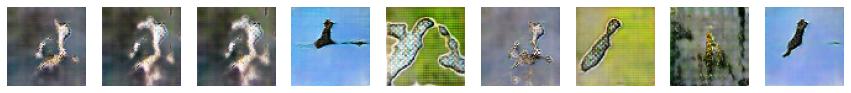

[ 3115  6652 11821 10276   612  8019  9752  9118  1920]
0 Blue_Grosbeak_0066_36632.jpg
1 Black_Throated_Sparrow_0015_107079.jpg
2 Common_Yellowthroat_0086_190639.jpg
3 Palm_Warbler_0100_168725.jpg
4 Yellow_Headed_Blackbird_0015_8207.jpg
5 Barn_Swallow_0093_130121.jpg
6 Chestnut_Sided_Warbler_0128_163696.jpg
7 Warbling_Vireo_0064_158437.jpg
8 Gray_Crowned_Rosy_Finch_0055_27112.jpg
(9, 64, 64, 3)


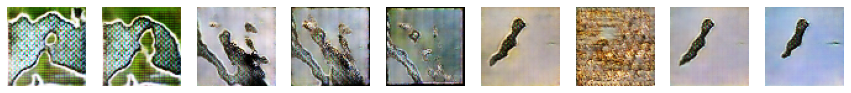

In [ ]:
gen_model = tf.keras.models.load_model('/content/drive/MyDrive/GAN_Text_to_images/Model/Gan_bird.h5')

for i in range(9):
  generate_images(gen_model, generate_latent_points(100, 9))

In [ ]:
test_input= generate_latent_points(100, 1)
predictions = gen_model(test_input, training=False)
pyplot.figure(figsize=[2, 2])
pyplot.imshow(array_to_img(predictions.numpy()[0]))

In [ ]:
def get_index_by_label(label):
  for idx, l in enumerate(labels):
    if l in label:
      return idx
print(get_index_by_label('Herring_Gull_0098_46971.jpg'))

In [ ]:
# Show image in image embeddings
print(labels[9161])
pyplot.figure(figsize=[8, 8])

pyplot.subplot(1, 2, 0+1)
pyplot.imshow(array_to_img(image_embeddings[7564]))
pyplot.axis('off')